In [3]:
import time
import logging
import numpy as np
import pandas as pd
import seaborn as sns
from time import time
from pathlib import Path
from pprint import pprint
from pandas import read_csv
from datetime import datetime
import matplotlib.pyplot as plt

# File system manangement
import os
# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# Sklearn processing
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.preprocessing import MinMaxScaler,StandardScaler, OneHotEncoder
from sklearn.model_selection import  StratifiedShuffleSplit,ShuffleSplit,RepeatedStratifiedKFold,StratifiedKFold

# Sklearn regression algorithms regression models.
from time import time
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression,SGDRegressor,Ridge,LinearRegression,Lasso
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, GradientBoostingRegressor

# Sklearn regression algorithms
# Sklearn regression model evaluation functions
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import explained_variance_score,mean_absolute_error,r2_score

# About Dataset:
A gas turbine is largely used to generate electricity around the world. In recent years, the awareness of greenhouse gases is raised and the emissions of the gas- turbines are controlled at certain limits according to the environmental regulations.

Aim of Homework : Building a machine learning model that can precisely estimate the volume of carbon monoxide (CO) emitted by a gas turbine is the goal of this project.

# Load Gas-Turbine CO Emission Data:

In [4]:
path1,path2 = "development.csv", "evaluation.csv"
# load all data from file that we will use for your homework
dev_tsv = pd.read_csv(path1,sep=',')
ev_tsv  = pd.read_csv(path2,sep=',')
#Add target columns in ev_tsv
ev_tsv["CO"] = -1

print("Shape of the original dataset: ")
print('development.shape :' ,dev_tsv.shape)
print('evaluation.shape  :' ,ev_tsv.shape)

print("show original dataset: ")
print("-------------------------------development-------------------------------------------")
print('development.shape :\n',dev_tsv.tail())
print("-------------------------------evaluation--------------------------------------------")
print('evaluation.shape :\n', ev_tsv.head())

# load all data from file that we will use for your homework
data_ev = ev_tsv.copy()
data_dev = dev_tsv.copy()

data = pd.concat([data_dev,data_ev],sort=True)
# resetting index
data.reset_index(inplace = True,drop=True)
# sort by index labels
data.sort_index(axis = 0,inplace = True) 
#
print('data.shape of all data  :' ,data.shape)

Shape of the original dataset: 
development.shape : (24488, 15)
evaluation.shape  : (12245, 15)
show original dataset: 
-------------------------------development-------------------------------------------
development.shape :
           ID  YEAR                 LOC       SN       AT      AP      AH  \
24483  24483  2020               Italy  0903XTR  10.0100  1012.7  86.073   
24484  24484  2018               Italy  0903XTR   2.4820  1029.7  87.328   
24485  24485  2022  Republic of Cyprus  0903XTR  27.4130  1012.4  59.496   
24486  24486  2019             Hungary  0903XTR   7.7894  1024.0  71.915   
24487  24487  2021      Czech Republic  0903XTR  29.7920  1012.4  65.672   

         AFDP    GTEP     TIT     TAT     TEY     CDP     NOX      CO  
24483  2.9555  24.000  1084.0  549.94  133.32  11.849  75.936  1.6001  
24484  4.7165  33.295  1100.0  529.85  166.64  14.197  49.785  2.2105  
24485  3.1360  20.205  1059.6  549.85  110.77  10.635  54.447  2.0096  
24486  2.3622  20.006  1051.

# Exploratory Data Analysis

In [6]:
data_train = dev_tsv.copy()
print("The number of '-' in the dataset:",data_train[data_train["NOX"]=='-'].shape[0])
#Replace '-' by '0' in the dataset.
data_train["NOX"] = data_train["NOX"].str.replace('-','0')
#Transform '0' in float.
data_train["NOX"] = data_train["NOX"].astype(float)
print("list of features in the dataset:", list(data_train.columns))

The number of '-' in the dataset: 12268
list of features in the dataset: ['ID', 'YEAR', 'LOC', 'SN', 'AT', 'AP', 'AH', 'AFDP', 'GTEP', 'TIT', 'TAT', 'TEY', 'CDP', 'NOX', 'CO']


# Check Any Missing values and Handling Missing values

In [42]:
total = data_train.isnull().sum().sort_values(ascending=False)
percent =total/len(data)*100
news=pd.concat([total,percent], axis=1, keys=['Total','Percent(%)'])
display(news)

,Total,Percent(%)
ID,0,0.0
YEAR,0,0.0
LOC,0,0.0
SN,0,0.0
AT,0,0.0
AP,0,0.0
AH,0,0.0
AFDP,0,0.0
GTEP,0,0.0
TIT,0,0.0


# Separate numeric and categorical variables

In [43]:
data_train.drop(['ID'], axis=1,inplace=True)
#Separate numeric and categorical variables
numeric_data = data_train.select_dtypes(include=[np.number])
categorical_data = data_train.select_dtypes(exclude=[np.number])

print("Part 1. Numeric")
print('Numeric columns: ',list(numeric_data.columns))
print('Shape of the numeric variables :' ,numeric_data.shape)
print("")
print("Part 2. Categorical")
print('Categorical columns: ',list(categorical_data.columns))
print('Shape of the categorical variables  :' ,categorical_data.shape)

Part 1. Numeric
Numeric columns:  ['YEAR', 'AT', 'AP', 'AH', 'AFDP', 'GTEP', 'TIT', 'TAT', 'TEY', 'CDP', 'NOX', 'CO']
Shape of the numeric variables : (24488, 12)

Part 2. Categorical
Categorical columns:  ['LOC', 'SN']
Shape of the categorical variables  : (24488, 2)


# Detection and treatment of outliers in numerical data

In [44]:
#Method 1: Detecting and Treating Outliers
#Removing outliers from data using Python and Pandas
def get_iqr_values_Specifying_quartile(df_in, col_name,first_quartile,third_quartile):
    median = df_in[col_name].median()
    q1 = df_in[col_name].quantile(first_quartile) # xth percentile / 1st quartile
    q3 = df_in[col_name].quantile(third_quartile) # yth percentile / 3rd quartile
    iqr = q3-q1 #Interquartile range
    minimum  = q1-1.5*iqr # The minimum value or the |- marker in the box plot
    maximum = q3+1.5*iqr # The maximum value or the -| marker in the box plot
    return median, q1, q3, iqr, minimum, maximum

def get_iqr_text_Specifying_quartile(df_in, col_name,first_quartile,third_quartile):
    median, q1, q3, iqr, minimum, maximum = get_iqr_values_Specifying_quartile(df_in, col_name,first_quartile,third_quartile)
    text = f"median={median:.2f}, q1={q1:.2f}, q3={q3:.2f}, iqr={iqr:.2f}, minimum={minimum:.2f}, maximum={maximum:.2f}"
    return text

def remove_outliers_Specifying_quartile(df_in, col_name,first_quartile,third_quartile):
    _, _, _, _, minimum, maximum = get_iqr_values_Specifying_quartile(df_in, col_name,first_quartile,third_quartile)
    df_out = df_in.loc[(df_in[col_name] > minimum) & (df_in[col_name] < maximum)]
    return df_out

def count_outliers_Specifying_quartile(df_in, col_name,first_quartile,third_quartile):
    _, _, _, _, minimum, maximum = get_iqr_values_Specifying_quartile(df_in, col_name,first_quartile,third_quartile)
    df_outliers = df_in.loc[(df_in[col_name] <= minimum) | (df_in[col_name] >= maximum)]
    return df_outliers.shape[0]

def box_and_whisker_Specifying_quartile(df_in, col_name,first_quartile,third_quartile):
    title = get_iqr_text_Specifying_quartile(df_in, col_name,first_quartile,third_quartile)
    #plt.figure(figsize=(5, 3))
    plt.figure(figsize=(16,8))
    sns.boxplot(df_in[col_name])
    plt.title(title)
    plt.show()
    
def Compare_the_plots_after_trimming(df_old,df_new,col_name,first_quartile,third_quartile):
    plt.figure(figsize=(16,8))
    plt.subplot(2,2,1)
    sns.distplot(df_old[col_name])
    plt.subplot(2,2,2)
    sns.boxplot(df_old[col_name])
    plt.subplot(2,2,3)
    sns.distplot(df_new[col_name])
    plt.subplot(2,2,4)
    sns.boxplot(df_new[col_name])
    plt.show()

#Replacing Outliers with Median Values
def Replacing_Outliers_Median_Specifying_quartile(df_in, col_name,first_quartile,third_quartile):
    median, _, _, _, minimum, maximum = get_iqr_values_Specifying_quartile(df_in, col_name,first_quartile,third_quartile)
    mask = (df_in[col_name] < minimum) | (df_in[col_name] > maximum)
    list_of_outliers = list(df_in[mask][col_name].values)
    df_in[col_name] = df_in[col_name].replace(list_of_outliers,median)
    return df_in

#Replacing Outliers with Mean Values
def Replacing_Outliers_Mean_Specifying_quartile(df_in, col_name,first_quartile,third_quartile):
    _, _, _, _, minimum, maximum = get_iqr_values_Specifying_quartile(df_in, col_name,first_quartile,third_quartile)
    mask = (df_in[col_name] < minimum) | (df_in[col_name] > maximum)
    list_of_outliers = list(df_in[mask][col_name].values)
    mean = df_in[col_name].mean()
    df_in[col_name] = df_in[col_name].replace(list_of_outliers,mean)
    return df_in

#Replacing Outliers with nan Values
def Replace_Outliers_with_nan_Specifying_quartile(df_in, col_name,first_quartile,third_quartile):
    median, q1, q3, iqr, minimum, maximum = get_iqr_values_Specifying_quartile(df_in, col_name,first_quartile,third_quartile)
    df_in.loc[df_in[col_name] < minimum,col_name] = np.nan
    df_in.loc[df_in[col_name] > maximum,col_name] = np.nan
    return df_in

def Finding_Outliers_using_plots(df_in,col_name):
    plt.figure(figsize=(16,8))
    plt.subplot(2,2,1)
    sns.distplot(df_in[col_name])
    plt.subplot(2,2,2)
    sns.boxplot(df_in[col_name])
    plt.show()
    
import plotly.express as px
def Box_Plot_with_plotly_express(df_in,col_in):
    fig = px.box(df_in[col_in])
    fig.show()

#Method 2: Detection_and_Remove_Outliers:
#This function remove of outliers records which present an outlier.
def Removing_Outlier_Using_IQR(X_in):
    features = X_in.columns
    to_clean = X_in.copy()
    indices = [x for x in to_clean.index]    
    out_indexlist = []
        
    for col in features:
       
        #We are using percentile 
        Q1 = np.percentile(to_clean[col], 25.)
        Q3 = np.percentile(to_clean[col], 75.)
        
        cut_off = (Q3 - Q1) * 1.5
        upper, lower = Q3 + cut_off, Q1 - cut_off
                
        outliers_index = to_clean[col][(to_clean[col] < lower) | (to_clean[col] > upper)].index.tolist()
        outliers = to_clean[col][(to_clean[col] < lower) | (to_clean[col] > upper)].values        
        out_indexlist.extend(outliers_index)
        
    #using set to remove duplicates
    out_indexlist = list(set(out_indexlist))
    clean_data = np.setdiff1d(indices,out_indexlist)
    return X_in.loc[clean_data]

In [45]:
dim = numeric_data.shape[0]
number_outliers = []
number_no_outliers = []
percentale_of_outliers = []
columns_with_outliers = []

for feature_name in numeric_data.columns.tolist():
    numbers = count_outliers_Specifying_quartile(numeric_data, feature_name,0.25,0.75)
    if numbers > 0:
        columns_with_outliers.append(feature_name)
        number_outliers.append(numbers)
        percentale_of_outliers.append(np.round((numbers/dim)*100,3))
        number_no_outliers.append(dim - numbers)
# initialize data of lists.
informations = {
        'Name_of_columns':columns_with_outliers,
        'number_outliers':number_outliers,
        'number_not_outliers': number_no_outliers,
        'Percentale_of_outliers(%)':percentale_of_outliers
       }
# Create DataFrame
df_informations = pd.DataFrame(informations)
  
# Print the output.
df_informations.sort_values(by=['Percentale_of_outliers(%)'], inplace=True,ascending=False)
df_informations

,Name_of_columns,number_outliers,number_not_outliers,Percentale_of_outliers(%)
6,TAT,3337,21151,13.627
9,CO,1681,22807,6.865
1,AP,468,24020,1.911
3,AFDP,368,24120,1.503
5,TIT,207,24281,0.845
2,AH,92,24396,0.376
7,TEY,25,24463,0.102
4,GTEP,8,24480,0.033
8,CDP,8,24480,0.033
0,AT,1,24487,0.004


In [46]:
#We will try the two mwthod and take which gives the best score.
#Treat_by_nan : we will replace all outliers by nan and we will apply KNN for Imputation to Handling Missing values.
Treat_by_nan = numeric_data.copy()

In [47]:
q1, q3 = 0.25,0.75
for feature_name in numeric_data.columns.tolist():
    #Replacing Outliers with nan Values
    Treat_by_nan = Replace_Outliers_with_nan_Specifying_quartile(Treat_by_nan, feature_name,q1, q3)

Minimum R2 score: 0.810214353126592 at K = 0
Maximun R2 score: 0.8397657798604339 at K = 5
KNN model implementation
Missing values in Dataset:  0


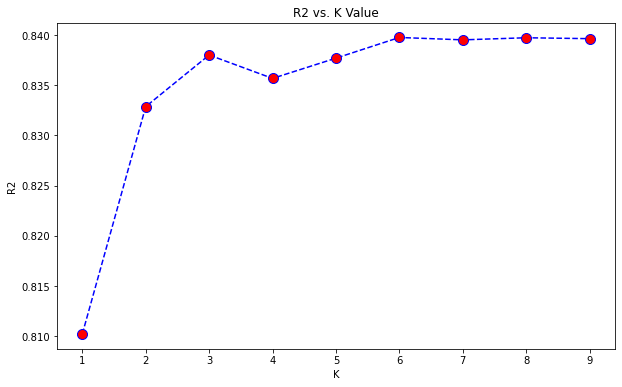

In [48]:
#(a) K-Nearest Neighbors(KNN) for Imputation
from sklearn.impute import KNNImputer
num_cols = Treat_by_nan.columns.tolist()
R2score = []
Remove = 'CO'
threshold = 0.2
for i in range(1,10):
    # Initializing KNNImputer
    knn = KNNImputer(n_neighbors = i)
    X = Treat_by_nan.copy()
    X = pd.DataFrame(knn.fit_transform(X), columns = num_cols)
    y =  X['CO']
    X.drop(Remove, axis = 1,inplace=True)
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=threshold,shuffle=True, random_state=42)
    model = ExtraTreesRegressor()
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    R2score.append(r2_score(y_test, y_pred))

plt.figure(figsize=(10,6))
plt.plot(range(1,10),R2score,color='blue', linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('R2 vs. K Value')
plt.xlabel('K')
plt.ylabel('R2')
print("Minimum R2 score:",min(R2score),"at K =",R2score.index(min(R2score)))
print("Maximun R2 score:",max(R2score),"at K =",R2score.index(max(R2score)))

print("KNN model implementation")
# Initializing KNNImputer
best_k=R2score.index(max(R2score))+1
knn = KNNImputer(n_neighbors = best_k)
X = knn.fit_transform(Treat_by_nan)
Treat_by_nan = pd.DataFrame(X, columns = num_cols)
#Check For Missing Values
print("Missing values in Dataset: ", Treat_by_nan.isnull().sum().sum())

In [49]:
#Treat_by_index: here we will samply removing index with outliers. 
Treat_by_index = numeric_data.copy()
Treat_by_index = Removing_Outlier_Using_IQR(Treat_by_index)
print(numeric_data.shape)
print(Treat_by_index.shape)
print(numeric_data.shape[0]-Treat_by_index.shape[0])

(24488, 12)
(19141, 12)
5347


# Evaluate th best method:

In [51]:
methods = [Treat_by_nan,Treat_by_index]
Remove=['CO']
for data,m in zip(methods,["method 1","method 2"]):
    print(f"We are evaluating {m} :")
    X = data.copy()
    X,y,threshold = X.drop(Remove, axis = 1),data['CO'], 0.2
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=threshold,shuffle=True, random_state=42)
    print ('x_train',X_train.shape)
    print ('y_train',y_train.shape)
    print ('x_valid',X_test.shape)
    print ('y_valid',y_test.shape)
    regressors = [ExtraTreesRegressor(),RandomForestRegressor()]
    for model in regressors:
        start = time()
        model.fit(X_train, y_train)
        train_time = time() - start
        start = time()
        y_pred = model.predict(X_test)
        predict_time = time()-start    
        print("\n\n>>>> without holdout submission:",model)
        print("\tTraining time: %0.3fs" % train_time)
        print("\tPrediction time: %0.3fs" % predict_time)
        print("\tExplained variance:", explained_variance_score(y_test, y_pred))
        print("\tMean absolute error:", mean_absolute_error(y_test, y_pred))
        print("\tMean square error: ", mean_squared_error(y_test, y_pred))
        print("\tRoot mean square error: ", np.sqrt(mean_squared_error(y_test, y_pred)))
        print("\tR2 score:", r2_score(y_test, y_pred))
    print("Ending of Evaluation")
    print()

We are evaluating method 1 :
x_train (19590, 11)
y_train (19590,)
x_valid (4898, 11)
y_valid (4898,)


>>>> without holdout submission: ExtraTreesRegressor()
	Training time: 4.380s
	Prediction time: 0.109s
	Explained variance: 0.840234452605077
	Mean absolute error: 0.34716142312485376
	Mean square error:  0.25891419424079326
	Root mean square error:  0.5088361172723427
	R2 score: 0.8402265442028376


>>>> without holdout submission: RandomForestRegressor()
	Training time: 10.898s
	Prediction time: 0.098s
	Explained variance: 0.8322716271623722
	Mean absolute error: 0.3569333693764802
	Mean square error:  0.27180902681807423
	Root mean square error:  0.5213530730877821
	R2 score: 0.8322692672028676
Ending of Evaluation

We are evaluating method 2 :
x_train (15312, 11)
y_train (15312,)
x_valid (3829, 11)
y_valid (3829,)


>>>> without holdout submission: ExtraTreesRegressor()
	Training time: 3.360s
	Prediction time: 0.088s
	Explained variance: 0.8151576736987547
	Mean absolute error: 0.

# Find Correlation between features and target 

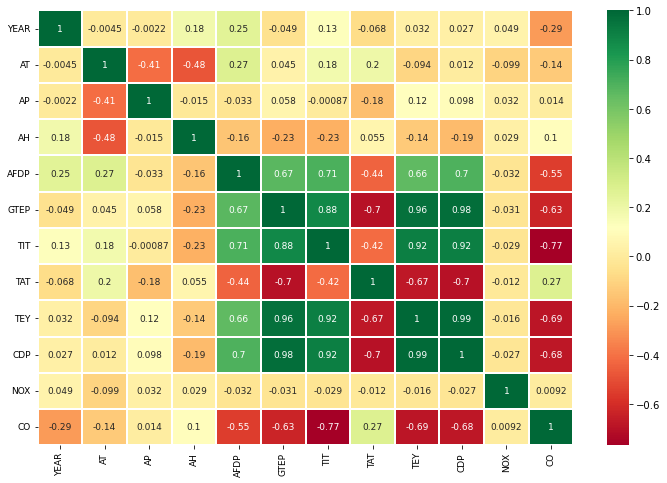

In [55]:
#Show Correlation between numericals features and target
#Lets print the correlation matrix to see interdependence between the features Pair plot
sns.heatmap(Treat_by_nan.corr(),annot=True,cmap='RdYlGn',linewidths=0.2,annot_kws={'size':9})
fig=plt.gcf()
fig.set_size_inches(12,8)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.show()

# Dealing with Multicollinearity


['GTEP', 'TIT', 'TAT', 'TEY', 'CDP', 'CO']


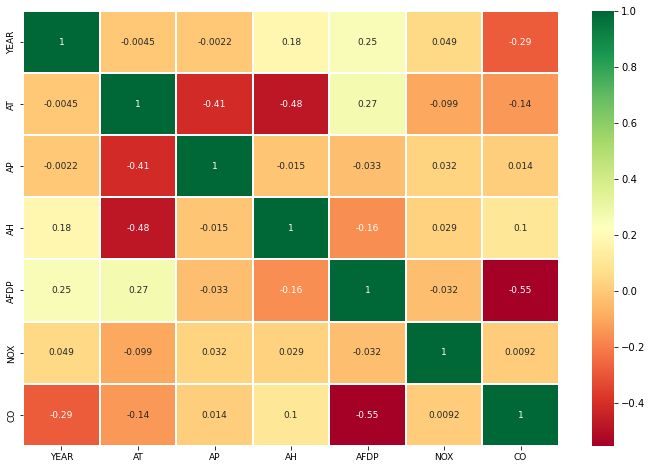

In [98]:
cor_matrix = Treat_by_nan.corr().abs()
#print(cor_matrix)

upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
#print(upper_tri)

to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.60)]
print(); print(to_drop)

df1 = Treat_by_nan.drop(['GTEP', 'TIT', 'TAT', 'TEY', 'CDP'], axis=1)
#Show Correlation between numericals features and target
#Lets print the correlation matrix to see interdependence between the features Pair plot
sns.heatmap(df1.corr(),annot=True,cmap='RdYlGn',linewidths=0.2,annot_kws={'size':9})
fig=plt.gcf()
fig.set_size_inches(12,8)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.show()

In [99]:
# Remove Correlated columns 
X = Treat_by_nan.copy()
X = X.drop(to_drop, axis = 1)
y = Treat_by_nan['CO']
threshold = 0.3
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=threshold,shuffle=True, random_state=42)
print ('x_train',X_train.shape)
print ('y_train',y_train.shape)
print ('x_valid',X_test.shape)
print ('y_valid',y_test.shape)
for model in regressors:
    start = time()
    model.fit(X_train, y_train)
    train_time = time() - start
    start = time()
    y_pred = model.predict(X_test)
    predict_time = time()-start    
    print("\n\n>>>> without holdout submission:",model)
    print("\tTraining time: %0.3fs" % train_time)
    print("\tPrediction time: %0.3fs" % predict_time)
    print("\tExplained variance:", explained_variance_score(y_test, y_pred))
    print("\tMean absolute error:", mean_absolute_error(y_test, y_pred))
    print("\tMean square error: ", mean_squared_error(y_test, y_pred))
    print("\tRoot mean square error: ", np.sqrt(mean_squared_error(y_test, y_pred)))
    print("\tR2 score:", r2_score(y_test, y_pred))
    print()

x_train (17141, 6)
y_train (17141,)
x_valid (7347, 6)
y_valid (7347,)


>>>> without holdout submission: ExtraTreesRegressor()
	Training time: 3.041s
	Prediction time: 0.178s
	Explained variance: 0.7429534824072275
	Mean absolute error: 0.4406052411232294
	Mean square error:  0.41564117975604825
	Root mean square error:  0.6447023962698202
	R2 score: 0.7429534377779416



>>>> without holdout submission: RandomForestRegressor()
	Training time: 5.836s
	Prediction time: 0.136s
	Explained variance: 0.7226840131447609
	Mean absolute error: 0.45748856121396486
	Mean square error:  0.4484168588397955
	Root mean square error:  0.669639349829291
	R2 score: 0.7226838493846177



# Principal Component Analysis

1. Method
1 Components capture 86.0% of variability of the data


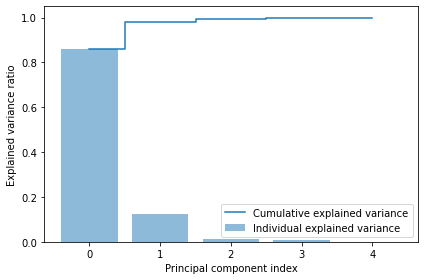

2. Method


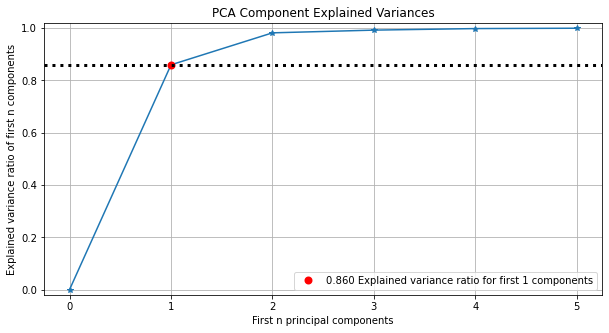

In [108]:
from sklearn.decomposition import PCA
select_feat = ['GTEP', 'TIT', 'TAT', 'TEY', 'CDP']
Treat_Mult = Treat_by_nan[select_feat].copy()
std = StandardScaler()
transformed = std.fit_transform(Treat_Mult)
pca = PCA().fit(transformed)
np_cum = np.cumsum(pca.explained_variance_ratio_)
print("1. Method")
df_cum = pd.DataFrame({'Component':[i for i in range(1,np_cum.shape[0]+1)],'cum_explained_variance_ratio':np_cum})
filter_df = df_cum[df_cum.cum_explained_variance_ratio>=0.8]
component = int(filter_df.Component.iloc[0])
cum_var = float(filter_df.cum_explained_variance_ratio.iloc[0])
print(f'{component} Components capture {round(cum_var,4)*100}% of variability of the data')
# Determine explained variance using explained_variance_ration_ attribute.
exp_var_pca = pca.explained_variance_ratio_
# Cumulative sum of eigenvalues; This will be used to create step plot
# for visualizing the variance explained by each principal component.
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
# Create the visualization plot
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

print("2. Method")
import scikitplot as skplt
skplt.decomposition.plot_pca_component_variance(pca,figsize=(10, 5))
plt.show()

In [105]:
new_dim=1
std = StandardScaler()
transformed = std.fit_transform(Treat_Mult)
pca = PCA(n_components=new_dim)
X_pca = pca.fit_transform(transformed)
df_pca = pd.DataFrame(data=X_pca, columns=["X_%s" % x for x in range(new_dim)])
print("original shape:   ", Treat_Mult.shape)
print("transformed shape:", df_pca.shape)
#display(df_pca.head(3))

original shape:    (24488, 5)
transformed shape: (24488, 1)


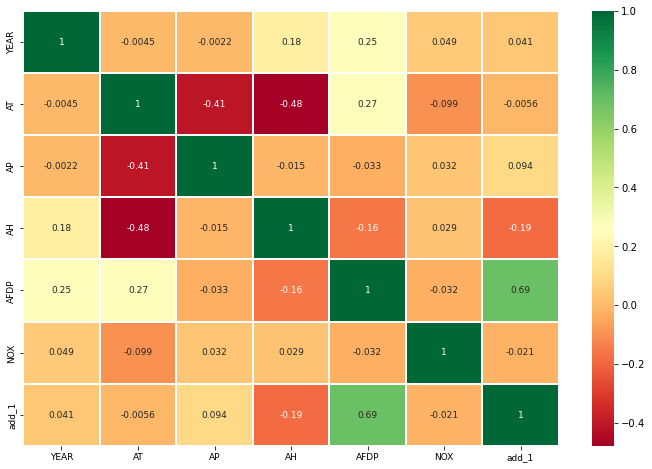



>>>> without holdout submission: ExtraTreesRegressor()
	Training time: 2.789s
	Prediction time: 0.146s
	Explained variance: 0.8260121594671485
	Mean absolute error: 0.3588570587634998
	Mean square error:  0.2813363386184541
	Root mean square error:  0.5304114804738431
	R2 score: 0.8260120936225348



>>>> without holdout submission: RandomForestRegressor()
	Training time: 6.157s
	Prediction time: 0.129s
	Explained variance: 0.8222540154322739
	Mean absolute error: 0.36508560121762623
	Mean square error:  0.2874140376837939
	Root mean square error:  0.5361100984721272
	R2 score: 0.8222534389774807



In [109]:
add_features = Treat_by_nan.copy()
add_features.drop(to_drop, axis=1,inplace=True)
add_features['add_1']=df_pca.values

#Show Correlation between numericals features and target
#Lets print the correlation matrix to see interdependence between the features Pair plot
sns.heatmap(add_features.corr(),annot=True,cmap='RdYlGn',linewidths=0.2,annot_kws={'size':9})
fig=plt.gcf()
fig.set_size_inches(12,8)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.show()

threshold = 0.3
X_train, X_test, y_train, y_test = train_test_split(add_features,y,test_size=threshold,shuffle=True, random_state=42)
for model in regressors:
    start = time()
    model.fit(X_train, y_train)
    train_time = time() - start
    start = time()
    y_pred = model.predict(X_test)
    predict_time = time()-start    
    print("\n\n>>>> without holdout submission:",model)
    print("\tTraining time: %0.3fs" % train_time)
    print("\tPrediction time: %0.3fs" % predict_time)
    print("\tExplained variance:", explained_variance_score(y_test, y_pred))
    print("\tMean absolute error:", mean_absolute_error(y_test, y_pred))
    print("\tMean square error: ", mean_squared_error(y_test, y_pred))
    print("\tRoot mean square error: ", np.sqrt(mean_squared_error(y_test, y_pred)))
    print("\tR2 score:", r2_score(y_test, y_pred))
    print()

# StandardScaler Transform

In [129]:
threshold = 0.3
X_train, X_test, y_train, y_test = train_test_split(add_features,y,test_size=threshold,shuffle=True, random_state=42)
# Standardize numerical features
print("Standardize numerical features with StandardScaler")
stdSc = StandardScaler()
X_train_Sc = X_train.copy()
X_test_Sc = X_test.copy()
X_train_Sc = stdSc.fit_transform(X_train_Sc)
X_test_Sc  = stdSc.transform(X_test_Sc)
model = ExtraTreesRegressor(random_state=0)
start = time()
model.fit(X_train_Sc, y_train)
train_time = time() - start
start = time()
y_pred = model.predict(X_test_Sc)
predict_time = time()-start    
print("\n\n>>>> Start evaluation model with:",model)
print("\tTraining time: %0.3fs" % train_time)
print("\tPrediction time: %0.3fs" % predict_time)
print("\tExplained variance:", explained_variance_score(y_test, y_pred))
print("\tMean absolute error:", mean_absolute_error(y_test, y_pred))
print("\tMean square error: ", mean_squared_error(y_test, y_pred))
print("\tRoot mean square error: ", np.sqrt(mean_squared_error(y_test, y_pred)))
print("\tR2 score:", r2_score(y_test, y_pred))
print("Ending of Evaluation")
print()

Standardize numerical features with StandardScaler


>>>> Start evaluation model with: ExtraTreesRegressor(random_state=0)
	Training time: 22.115s
	Prediction time: 1.134s
	Explained variance: 0.8262316493174415
	Mean absolute error: 0.3590022134410689
	Mean square error:  0.28098209427861176
	Root mean square error:  0.5300774417748899
	R2 score: 0.8262311703025609
Ending of Evaluation



# plot graph of feature importances for better visualization

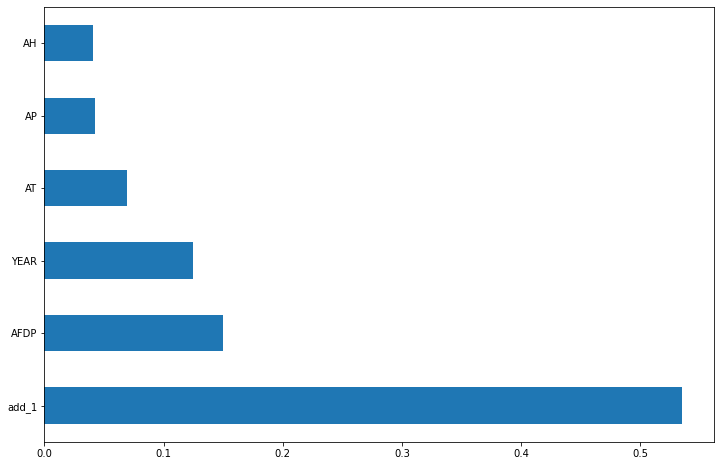

In [126]:
#plot graph of feature importances for better visualization
plt.figure(figsize = (12,8))
feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
feat_importances.nlargest(6).plot(kind='barh')
plt.show()

# Hyperparameter tuning with Random search

In [135]:
# Use the random grid to search for best hyperparameters
model = ExtraTreesRegressor(random_state=0)
print('Parameters currently in use:\n')
pprint(model.get_params())
#------------### Hyperparameter Tuning ###---------------#
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 500, num = 3)]
max_depth.append(None)
# Number of features to consider at every split
max_features = ['auto', 'sqrt','log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 200, num = 3)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
criterion=['friedman_mse','squared_error','mse']

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'criterion': criterion
              }
print("Random Hyperparameter Grid")
pprint(random_grid)

# Random search of parameters, using 3 fold cross validation, 
rf_random = RandomizedSearchCV(estimator = model, 
                               param_distributions = random_grid,
                               scoring='neg_mean_squared_error', 
                               n_iter = 100, 
                               cv = 3, 
                               verbose=2,
                               random_state=42,
                               n_jobs = -1)

print("Train model with grid:")
rf_random.fit(X_train_Sc, y_train)

print("Best hyperparameters:")
print(rf_random.best_params_)

Parameters currently in use:

{'bootstrap': False,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}
Random Hyperparameter Grid
{'bootstrap': [True, False],
 'criterion': ['friedman_mse', 'squared_error', 'mse'],
 'max_depth': [10, 105, 200, None],
 'max_features': ['auto', 'sqrt', 'log2'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [50, 275, 500]}
Train model with grid:
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best hyperparameters:
{'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 200, 'criterion': 'squared_error', 'bootstrap': False}


In [138]:
print("--- Part 1: Train model without setting hyperparameters:")
rnf = ExtraTreesRegressor(random_state=0)
rnf.fit(X_train_Sc, y_train)
y_preds = rnf.predict(X_test_Sc)
print("MSE(base_model) : {:.3f} ".format(mean_squared_error(y_test, y_preds)))
print("R2 score(base_model) : {:.3f} ", r2_score(y_test, y_preds))
print("--- Part 2: Train model with hyperparameters:")
best_random = rf_random.best_estimator_
best_random.fit(X_train_Sc, y_train)
y_pred = best_random.predict(X_test_Sc)
print("MSE(best_model) : {:.3f} ".format(mean_squared_error(y_test, y_pred)))
print("R2 score(best_model) : {:.3f} ", r2_score(y_test, y_pred))

--- Part 1: Train model without setting hyperparameters:
MSE(base_model) : 0.281 
R2 score(base_model) : {:.3f}  0.8262311703025609
--- Part 2: Train model with hyperparameters:
MSE(best_model) : 0.278 
R2 score(best_model) : {:.3f}  0.8279850424228897
